In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [332]:
# __ are dunder methods, or special methods. we are doing operator over-loading i.e. allowing classes to define their own behavior for Python operators. 
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) # set of children
        self._backward = lambda: None
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other  
    def __truediv__(self, other): 
        return self * (other ** -1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** (other), (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward 
        return out 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1
    
    def __rsub__(self, other):
        return -self + other
    def __sub__(self, other):
        return self + (-other)

    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out 

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1 - t ** 2)
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [64]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label=" {%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

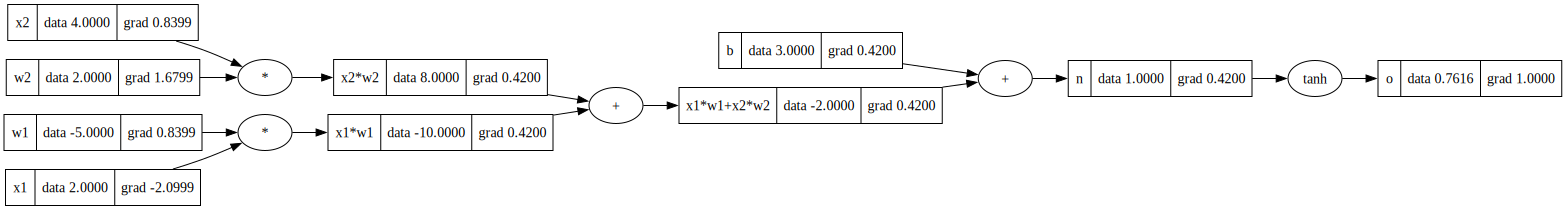

In [216]:
# inputs x1, x2, weights w1, w2
x1 = Value(2.0, label='x1')
x2 = Value(4.0, label='x2')
w1 = Value(-5.0, label='w1')
w2 = Value(2.0, label='w2')
b = Value(3.0, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

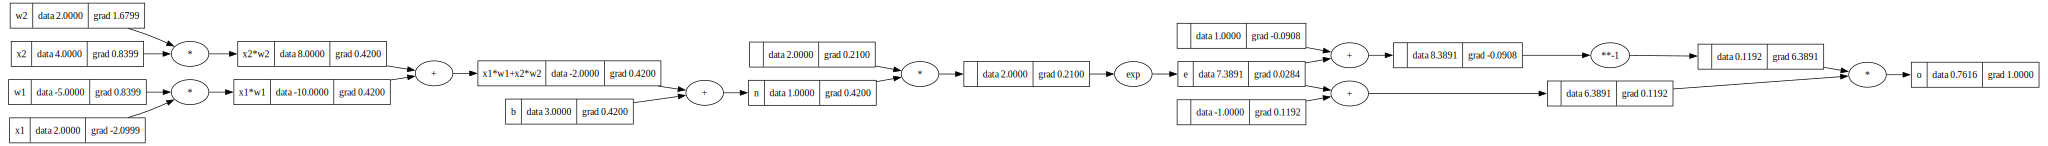

In [218]:
# inputs x1, x2, weights w1, w2
x1 = Value(2.0, label='x1')
x2 = Value(4.0, label='x2')
w1 = Value(-5.0, label='w1')
w2 = Value(2.0, label='w2')
b = Value(3.0, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp(); e.label='e'
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch, random

In [233]:
# double is float64, regular float is float32
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([4.0]).double()
w1 = torch.Tensor([-5.0]).double()
w2 = torch.Tensor([2.0]).double()
b = torch.Tensor([3.0]).double()

# by default, torch sets the require grad to false
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

#.item() strips away the tensor and just outputs the value
print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7615941559557649
x1 -2.099871708070131
w1 0.8399486832280523
x2 0.8399486832280523
w2 1.6798973664561045
tensor([4.], dtype=torch.float64, requires_grad=True)


In [348]:
class Neuron:
    def __init__(self, n_input):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(n_input)]
        self.b = Value(np.random.uniform(-1, 1))
    
    # Neuron(x)
    def __call__(self, x):
        # sum starts with a initial value
        act = sum([x * y for x, y in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, n_input, n_output):
        self.neurons = [Neuron(n_input) for _ in range(n_output)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs 
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, n_input, n_output):
        size = [n_input] + n_output
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_output))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [522]:
nn = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]
ys = [1, -1, -1, 1]


In [562]:
# implementing gradient descent
for k in range(50):
    # forward pass 
    ypred = [nn(x) for x in xs]
    loss = sum((y1 - y2)**2 for y1, y2 in zip(ys, ypred))
    
    # backward pass, need to first zero grad because the gradients are accumulated from the previous backward pass
    for p in nn.parameters():
        p.grad = 0
    loss.backward()

    # update 
    for p in nn.parameters():
        p.data += -0.5 * p.grad
    
    print(k, loss.data)

0 2.1121370019414102e-05
1 2.1109774985393222e-05
2 2.109819256036727e-05
3 2.1086622723851655e-05
4 2.1075065455403268e-05
5 2.1063520734625994e-05
6 2.1051988541165865e-05
7 2.1040468854713915e-05
8 2.1028961655004515e-05
9 2.1017466921815704e-05
10 2.1005984634969302e-05
11 2.0994514774332017e-05
12 2.0983057319809678e-05
13 2.0971612251353656e-05
14 2.096017954896019e-05
15 2.0948759192667523e-05
16 2.0937351162554425e-05
17 2.0925955438747325e-05
18 2.0914572001408292e-05
19 2.090320083074861e-05
20 2.0891841907017758e-05
21 2.0880495210509335e-05
22 2.0869160721557468e-05
23 2.085783842054255e-05
24 2.0846528287882102e-05
25 2.083523030403621e-05
26 2.0823944449510078e-05
27 2.0812670704846727e-05
28 2.0801409050632958e-05
29 2.0790159467495462e-05
30 2.0778921936103767e-05
31 2.0767696437167247e-05
32 2.0756482951437694e-05
33 2.0745281459706323e-05
34 2.0734091942806513e-05
35 2.0722914381610426e-05
36 2.071174875703505e-05
37 2.0700595050031267e-05
38 2.068945324159752e-05
39 

In [563]:
ypred

[Value(data=0.9975747557428061),
 Value(data=-0.9981035148718254),
 Value(data=-0.9978660520508404),
 Value(data=0.9974435427128666)]